## A/B–тестирование  
#### Условие
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Проанализируем итоги эксперимента и сделаем вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### В качестве входных данных 4 csv-файла:  

groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)   
groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

## Этап 1. Загрузка файлов, чтение, EDA, объединение, очистка

##### 1. Загрузка данных с публичного доступа ЯндексДиск

In [4]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode



# Список публичных ссылок на файлы
groups_yd       = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'  
groups_add_yd   = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'          
active_studs_yd = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'          
checks_yd       = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'          

#функция для скачивания 

def get_yd(public_key: str) -> str:

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode({'public_key': public_key})
    response = requests.get(final_url)
    response.raise_for_status()  # выбросит ошибку, если запрос неудачен
    download_url = response.json()['href']
    
    return download_url

# Итоговые файлы
groups       = pd.read_csv(get_yd(groups_yd), sep=';')
groups_add   = pd.read_csv(get_yd(groups_add_yd))
active_studs = pd.read_csv(get_yd(active_studs_yd), sep=';')
checks       = pd.read_csv(get_yd(checks_yd), sep=';')


##### 2. EDA по каждому df

a. Анализируем данные файла **groups** -  принадлежность пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [5]:
#посмотрим на df первые 5 строк
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
#посмотрим на df последние 5 строк
groups.tail()

,id,grp
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B
74483,5694419,B


In [7]:
#проверка пропусков и дубликатов 

def check_data(groups):
    
    print("=== Тип данных ===")
    print(groups.dtypes) 
    
    print("\n=== Размер ===")
    print(groups.shape)
    
    print("\n=== Пропуски ===")
    print(groups.isna().sum())
    
    print("\n=== Дубликаты ===")
    print(f"Всего дубликатов: {groups.duplicated().sum()}")
    
check_data(groups)

=== Тип данных ===
id      int64
grp    object
dtype: object

=== Размер ===
(74484, 2)

=== Пропуски ===
id     0
grp    0
dtype: int64

=== Дубликаты ===
Всего дубликатов: 0


In [8]:
#кол-во в разрезе групп
groups.groupby('grp')['id'].count()

grp
A    14671
B    59813
Name: id, dtype: int64

b. Анализируем данные **groups_add** - файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [9]:
#посмотрим на df первые 5 строк
groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
#посмотрим на df последние 5 строк
groups_add.tail()

,id,grp
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B
91,201067659,B


In [11]:
#проверка типа данных, размера, пропусков и дубликатов 

def check_data(groups_add):
    
    print("=== Тип данных ===")
    print(groups_add.dtypes) 
    
    print("\n=== Размер ===")
    print(groups_add.shape)
    
    print("\n=== Пропуски ===")
    print(groups_add.isna().sum())
    
    print("\n=== Дубликаты ===")
    print(f"Всего дубликатов: {groups_add.duplicated().sum()}")
    
check_data(groups_add)

=== Тип данных ===
id      int64
grp    object
dtype: object

=== Размер ===
(92, 2)

=== Пропуски ===
id     0
grp    0
dtype: int64

=== Дубликаты ===
Всего дубликатов: 0


In [12]:
#кол-во в разрезе групп
groups_add.groupby('grp')['id'].count()

grp
A    22
B    70
Name: id, dtype: int64

c. Анализируем данные файла **active_studs** -  пользователи, которые зашли на платформу в дни проведения эксперимента. 

In [13]:
#посмотрим на df первые 5 строк
active_studs.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [14]:
#посмотрим на df последние 5 строк
active_studs.tail()

,student_id
8336,1794344
8337,296883
8338,3598448
8339,3610547
8340,205705


In [15]:
#проверка типа данных, размера, пропусков и дубликатов 

def check_data(active_studs):
    
    print("=== Тип данных ===")
    print(active_studs.dtypes) 
    
    print("\n=== Размер ===")
    print(active_studs.shape)
    
    print("\n=== Пропуски ===")
    print(active_studs.isna().sum())
    
    print("\n=== Дубликаты ===")
    print(f"Всего дубликатов: {active_studs.duplicated().sum()}")
    
check_data(active_studs)

=== Тип данных ===
student_id    int64
dtype: object

=== Размер ===
(8341, 1)

=== Пропуски ===
student_id    0
dtype: int64

=== Дубликаты ===
Всего дубликатов: 0


d. Анализируем данные **checks** - файл с информацией об оплатах пользователей в дни проведения эксперимента

In [16]:
#посмотрим на df первые 5 строк
checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [17]:
#посмотрим на df последние 5 строк
checks.tail()

,student_id,rev
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0
540,5740903,1900.0


In [18]:
#проверка типа данных, размера, пропусков и дубликатов 

def check_data(checks):
    
    print("=== Тип данных ===")
    print(checks.dtypes) 
    
    print("\n=== Размер ===")
    print(checks.shape)
    
    print("\n=== Пропуски ===")
    print(checks.isna().sum())
    
    print("\n=== Дубликаты ===")
    print(f"Всего дубликатов: {checks.duplicated().sum()}")
    
check_data(checks)

=== Тип данных ===
student_id      int64
rev           float64
dtype: object

=== Размер ===
(541, 2)

=== Пропуски ===
student_id    0
rev           0
dtype: int64

=== Дубликаты ===
Всего дубликатов: 0


Есть группа А контрольная и B тестовая. Размерность в группах разная. Проверим дальше. Дублей нет, пустых тоже. Названия в файлах отличается.

##### 3. Объединяем датафреймы, заменяем пустые значения для дальнейших расчетов


In [19]:
#добавляем в df groups данные с groups_add
groups_all = pd.concat([groups, groups_add])
# кол-во строк groups - 74484, groups_add - 92  =groups_all - 74576 - ничего не потеряли

In [20]:
#объединяем groups_all с active_studs для добавления инфо об активных пользователях(те, кто зашли в дни эксперимента)
df_all_activ = pd.merge(groups_all,  active_studs, left_on='id', right_on='student_id', how='left')

#объединяем новый df с checks для добавления инфо об оплатах пользователях(те, кто оплатил в дни эксперимента)
df = pd.merge(df_all_activ, checks, left_on='id', right_on='student_id', how='left')

#переименуем столбцы 
df = df.rename(columns={'grp': 'group',
                        'student_id_x': 'active_stud',
                        'student_id_y': 'pay_stud',
                        'rev': 'payment'}) 

Замена пустых значений

In [21]:
#заменим пустые на 0; а ячейки, где указаны id студента заменим на 1. Тобиш активный юзер=1, неактивный=0
df['active_stud'] = df['active_stud'].notna().astype(int)

#аналогично для столбца pay_stud (платящий=1, неплатящий=0)
df['pay_stud'] = df['pay_stud'].notna().astype(int)

#заполним пропуски нулями, но при расчетах будем иметь ввиду, т.к. тут значения
df['payment'] = df['payment'].fillna(0) 

Проверка на аномалии в данных

In [22]:
#проверим на то, есть ли неактиные пользователи среди оплативших

unactiv_pay_stud = df.query('pay_stud == 1 and active_stud == 0')
unactiv_pay_stud.shape

(149, 5)

Найдено 149 пользователей, которые платили, но не не были активны во время эксперимента. Мы их должны исключить, так как это не связано с проведением эксперимента.

In [23]:
#удалим из df 149 пользователей

df_cleaned = df[~((df['pay_stud'] == 1) & (df['active_stud'] == 0))]
df_cleaned = df

In [24]:
#доля активных от всех пользователей
df.query("active_stud== 1").id.count() / df.id.count() *100


11.184563398412358

In [25]:
df = df.query("active_stud== 1")
df.head()

,id,group,active_stud,pay_stud,payment
1,1627,A,1,1,990.0
10,2085,B,1,0,0.0
12,2215,B,1,0,0.0
43,3391,A,1,0,0.0
45,3401,B,1,0,0.0


Для расчетов оставим только тех пользователей которые были активны в дни эксперимента, т.к. доля всего лишь 11,2% от всех пользователей

Итого предварительные выводы:  
    - найденные аномалии удалены  
    - количество пользователей в группах разное  
    - для расчетов оставим только тех пользователейЮ, которые были активны в дни эксперимента, т.к. доля всего лишь 11,2%

## Этап 2. Разделение данных по группам, предварительный анализ и выбор метрик

##### 1. Разделим df на группы, посмотрим методом .describe предварительный анализ

###### Исследуем Контрольную группу (А)

In [26]:
#контрольная группа А
group_a = df.query('group == "A"').reset_index(drop=True) 

In [27]:
#посмотрим на данные. выбираем только те, где были платежи
group_a.query('payment > 0').payment.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: payment, dtype: float64

In [28]:
#посчитаем кол-во выбросов т.к. медиана = 585, среднее = 933, максимум = 3660 свидетельствует о разбросе данных

Q1 = 290.0    # 25%-й перцентиль
Q3 = 1114.7    # 75%-й перцентиль
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR  
upper_bound = Q3 + 1.5 * IQR   

# Число выбросов
outliers = group_a[(group_a['payment'] > upper_bound) & (group_a['payment'] > 0)]
print(f"Число выбросов: {len(outliers)}") 

Число выбросов: 9


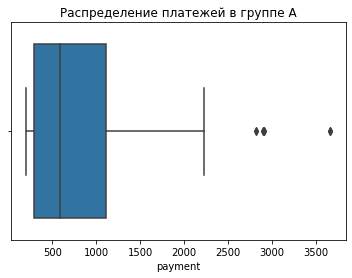

In [29]:
#построим боксплот
sns.boxplot(x=group_a[group_a['payment'] > 0]['payment'])
plt.title('Распределение платежей в группе A')
plt.show()

###### Исследуем Тестовую/Целевую группу (B)

In [30]:
#тестовая группа В
group_b = df.query('group == "B"').reset_index(drop=True) 

In [31]:
group_b.query('payment > 0').payment.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: payment, dtype: float64

In [32]:
Q1_1 = 511.75    # 25%-й перцентиль
Q3_1 = 1900.0    # 75%-й перцентиль
IQR_1 = Q3_1 - Q1_1 

# Границы для выбросов
lower_bound_1 = Q1_1 - 1.5 * IQR_1  
upper_bound_1 = Q3_1 + 1.5 * IQR_1   

# Число выбросов
outliers_1 = group_b[(group_b['payment'] > upper_bound_1) & (group_b['payment'] > 0)]
print(f"Число выбросов: {len(outliers_1)}")  

Число выбросов: 1


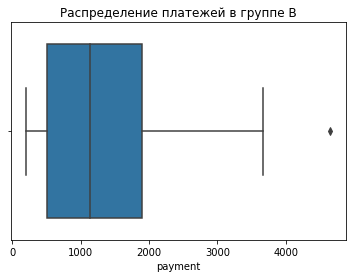

In [33]:
sns.boxplot(x=group_b[group_b['payment'] > 0]['payment'])
plt.title('Распределение платежей в группе B')
plt.show()

Итого: 
- Тестовая группа B платит больше: Медиана увеличилась в 2 раза, средний чек выше на 35%

- Платежи в группе B стабильнее: Меньший разброс (стандартное отклонение в тестовой =919 vs 790(в контрольной)). Более высокие 25%-й и 75%-й перцентили — в группе (В) существенно выше.

- Выбросы есть в обеих группах: Максимальные платежи: 3660 руб. (A) vs 4650 руб. (B). Но в группе (B) 75%-й перцентиль уже 1900 руб. (против 1114 руб. в A) — значит, крупные платежи не единичны.

##### 2. Выбор метрик и расчет

1. **ARPPU** (Average Revenue Per Paying Use) - средний доход на одного **платящего** пользователя. Используется для оценки дохода, получаемого от пользователей, совершающие покупки. Применятся, когда важно понять, сколько денег приносит каждый платящий пользователь.
Является продуктовой метрикой, а не метрикой роста. Её можно посчитать. Она интерпретируемая: увеличив число платящих пользователей, мы сможем увидеть эффект в среднем доходе в сегменте платящих пользователей. Она чувствительна: среднее хорошо отражает изменения.

In [34]:
#считаем общий доход от платящих пользователей по **контрольной группе**
total_payment_a  = group_a.query('pay_stud == 1').payment.sum()

#считаем кол-во платящих пользователей
total_pay_stud_a = group_a.query('pay_stud == 1').pay_stud.sum()

arppu_group_a    = total_payment_a / total_pay_stud_a
print(f"ARPPU по контрольной группе: {arppu_group_a}")

ARPPU по контрольной группе: 933.5897435897435


In [35]:
# аналогичный расчет ARPPU по **тестовой группе**
total_payment_b   = group_b.query('pay_stud == 1').payment.sum() #доход
total_pay_stud_b  = group_b.query('pay_stud == 1').pay_stud.sum() #кол -во
arppu_group_b     = total_payment_b / total_pay_stud_b

print(f"ARPPU по тестовой группе: {arppu_group_b}")

ARPPU по тестовой группе: 1257.8789920382164


2. **Конверсия в оплату** - процент пользователей, совершивших хотя бы одну оплату от общего числа активных пользователей. Берем эту метрику, т.к. основная цель изменения - увеличить количество оплат. Также является продуктовой метрикой, а не метрикой роста. Подходит по всем свойствам(достоверность, интерпретируемость, чувствительность). Её легко посчитать. Наше изменение направлено на увеличение конверсии. Метрика чувствительна: конверсионные метрики хорошо реагируют на изменения и подходят для экспериментов.

In [36]:
#общее кол-во активных пользователей в **контрольной группе**
total_active_stud_a  = group_a.query('active_stud == 1').active_stud.sum()

# Конверсия в оплату
conversation_group_a = total_pay_stud_a / total_active_stud_a * 100

print(f"Конверсия в оплату по контрольной группе: {conversation_group_a}")

Конверсия в оплату по контрольной группе: 5.071521456436931


In [37]:
#аналогичный расчет конверсии в оплату в **тестовой группе**
total_active_stud_b  = group_b.query('active_stud == 1').active_stud.sum()
conversation_group_b = total_pay_stud_b / total_active_stud_b * 100

print(f"Конверсия в оплату по тестовой группе: {conversation_group_b}")

Конверсия в оплату по тестовой группе: 4.615610759958842


3. **ARPU** (Average Revenue Per Use)- средний доход на всех пользователей.

In [38]:
#общий доход  по **контрольной группе** ранее считали =total_payment_a

#считаем кол-во всех пользователей
total_stud_a= group_a.active_stud.sum()

arpu_group_a = total_payment_a / total_stud_a

print(f"ARPPU по контрольной группе: {arpu_group_a}")

ARPPU по контрольной группе: 47.34720416124838


In [39]:
#общий доход  по **тестовой группе** ранее считали =total_payment_b

#считаем кол-во всех пользователей
total_stud_b = group_b.active_stud.sum()

arpu_group_b = total_payment_b / total_stud_b

print(f"ARPPU по контрольной группе: {arpu_group_b}")

ARPPU по контрольной группе: 58.05879810377775


Сравнение данных по метрикам

In [40]:
metrics = pd.DataFrame({
    'Метрики': ['ARPPU', 'ARPU', 'Конверсия'],
    'Группа A - контрольная ': [arppu_group_a, arpu_group_a, conversation_group_a],
    'Группа B - тестовая':     [arppu_group_b, arpu_group_b, conversation_group_b],
    'Difference (B - A)':      [arppu_group_b - arppu_group_a,
                                arpu_group_b - arpu_group_a,
                                conversation_group_b - conversation_group_a]
})
print(metrics)

     Метрики  Группа A - контрольная   Группа B - тестовая  Difference (B - A)
0      ARPPU               933.589744          1257.878992          324.289248
1       ARPU                47.347204            58.058798           10.711594
2  Конверсия                 5.071521             4.615611           -0.455911


Итог по метрикам:  
 - ARPPU (средний доход на одного платящего пользователя) и ARPU (средний доход от всех активных пользователей) в тестовой группе оказался выше, чем в контрольной.
 - Конверсия в оплату среди активных пользователей в контрольной оказался выше.  
 
 Для принятия решения о принятии/отказе от новой механики оплаты проанализируем метрики (ARPPU и конверсию в оплату).

## Этап 3. A/B - тест 

### ARPPU

##### 1. Проверка на нормальность распределения  
H_0: ГС, из которой взята эта выборка, распределена нормально   
H_1: ГС, из которой взята эта выборка, распределена не нормально

In [41]:
#для контрольной группы
stats.normaltest(df.query('group == "A" and pay_stud == 1').payment)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

In [42]:
#для тестовой группы
stats.normaltest(df.query('group == "B" and pay_stud == 1').payment)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

Распределение ненормальное. В обоих случаях p_value < 0.05.

##### 2. Проверка на равенство дисперсий  
H_0: дисперсии не различаются   
H_1: дисперсии различаются

In [43]:
payments_a = group_a.query('pay_stud == 1')['payment'].values #контрольная
payments_b = group_b.query('pay_stud == 1')['payment'].values #тестовая

levene_stat, levene_p_value = stats.levene(payments_a, payments_b)
levene_stat, levene_p_value

(3.075681699981606, 0.08025675761347022)

Дисперсии в группах стат.значимо не различаются. p_value > 0.05

##### 3. Для сравнения данных выбираем Ttest, так как его нужно использовать при сравнении средних.

 Для начала сформулируем гипотезы для проверки
- H0: Средние в контрольной и тестовой группе НЕ отличаются. 
- H1: Средние в контрольной и тестовой группе отличаются. 

In [44]:
# создаем список с инфо об оплате от платящих пользователей для **контрольной группы**
payments_a = group_a.query('pay_stud == 1')['payment'].values
payments_b = group_b.query('pay_stud == 1')['payment'].values #тестовая

t_statistic, p_value = stats.ttest_ind(payments_a, payments_b)

print(f'T-статистика: {t_statistic}, P-значение: {p_value}')

T-статистика: -3.1337795050930985, P-значение: 0.0018562025265765867


P-value (0.0025) < 0.05. Результат **статистически значим** и позволяет отвергнуть нулевую гипотезу о равенстве средних в контрольной и тестовой группе. 

##### 4. Визуализация

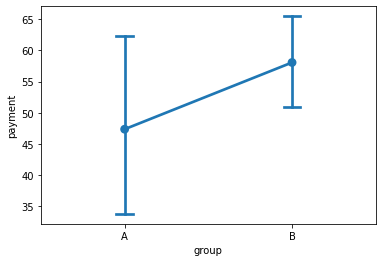

In [45]:
sns.pointplot(x="group", #название группирующей переменной
              y="payment", #название переменной, которую мы сравниваем
              data=df, #датафрейм с данными
              capsize=0.1) #длина засечек на конце "усов" - можно убрать

ARPPU в тестовой группе выше, новая механика оплаты лучше, т.к. средний доход на активного платящего пользователя вырос.

### Конверсия в оплату

Используем хи-квадрат, так как данные категориальные
 
- H0: Механикам оплаты не влияет на конверсию в оплату. Доля платящих пользователей в тестовой (B) и контрольной (A) группах одинакова
- H1: Механикам оплаты влияет на конверсию в оплату. Доля платящих пользователей в тестовой (B) и контрольной (A) группах НЕ одинакова

1. Создадим таблицу сопряженности (будут указаны группы и кол-во пользователей, которые совершили оплату(pay_stud=1),
и тех, кто не совершил оплату(pay_stud=0)

In [46]:
contingency_table = pd.crosstab(
                                index=df['group'],    # Строки — группы A/B
                                columns=df['pay_stud'],  # Столбцы — оплата (0 или 1)
                                margins=True,         # Добавить итоговые строки/столбцы
                                margins_name='Итого'  # Название для итогов
)

print(contingency_table)

pay_stud     0    1  Итого
group                     
A         1460   78   1538
B         6489  314   6803
Итого     7949  392   8341


2. Визуализируем

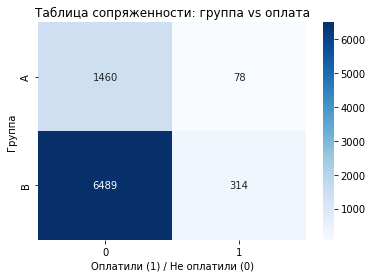

In [47]:
sns.heatmap(contingency_table.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues')
plt.title('Таблица сопряженности: группа vs оплата')
plt.xlabel('Оплатили (1) / Не оплатили (0)')
plt.ylabel('Группа')
plt.show()

#группа А(контольная), группа B(тестовая)

3. Проведем тест

In [48]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f'Статистика хи-квадрат: {chi2_stat}')
print(f'P-значение: {p_value}')

Статистика хи-квадрат: 0.5821513741106591
P-значение: 0.9650262748206196


P-значение > 0.05 Нулевую гипотезу не отвергаем. Вывод о различиях в конверсии сделать не можем.

## ИТОГО

На такими представленными данными я бы сделала вывод о том, что нужно запускать новый механику оплаты на всех пользователей.
Почему? По сравнению **средних** получили статистически значимое различие. При расчете показателя ARPPU средний доход на платящего пользователя также увеличилась на 35%. Если же основная цель в увеличении дохода (а это в коммерции всегда является основной целью), то новую механику выкатываем на всех пользователей.
Несмотря на результат по анализу метрики - конверсия в оплату.


- Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
- Реализуем функцию, которая будет строить графики по получаемым метрикам.

1. Загрузка файлов

In [49]:
#список публичных ссылок на основные файлы
groups_yd       = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'            
active_studs_yd = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'          
checks_yd       = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'          

#публичная ссылка на доп. файл
groups_add_yd    = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'


#функция для скачивания 

def get_yd(public_key: str) -> str:

    base_url  = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode({'public_key': public_key})
    response  = requests.get(final_url)
    response.raise_for_status()  # выбросит ошибку, если запрос неудачен
    download_url = response.json()['href']
    return download_url

#итоговые файлы
groups       = pd.read_csv(get_yd(groups_yd), sep=';')
groups_add   = pd.read_csv(get_yd(groups_add_yd))
active_studs = pd.read_csv(get_yd(active_studs_yd), sep=';')
checks       = pd.read_csv(get_yd(checks_yd), sep=';')


2. Расчет метрик

In [50]:
def calculate_metrics(data):
    
    #объединим df
    groups_all = pd.concat([groups, groups_add]) #groups с groups_add
    df_all_activ = pd.merge(groups_all,  active_studs, left_on='id', right_on='student_id', how='left') #groups_all с active_studs 
    df = pd.merge(df_all_activ, checks, left_on='id', right_on='student_id', how='left') #df_all_activ c checks

    #переименуем
    df = df.rename(columns={'grp': 'group',
                        'student_id_x': 'active_stud',
                        'student_id_y': 'pay_stud',
                        'rev': 'payment'}) 

    #заменим пустые на 0; id студента заменим на 1
    df['active_stud'] = df['active_stud'].notna().astype(int)    
    df['pay_stud'] = df['pay_stud'].notna().astype(int)
    df['payment'] = df['payment'].fillna(0)

    #проверим на то, есть ли неактиные пользователи среди оплативших
    unactiv_pay_stud = df.query('pay_stud == 1 and active_stud == 0')

    #доля активных от всех пользователей
    df.query("active_stud== 1").id.count() / df.id.count() *100

    #оставим только активных пользователей
    df = df.query("active_stud== 1")
    group_a = df.query('group == "A"').reset_index(drop=True) #разделение на группы A и B
    group_b = df.query('group == "B"').reset_index(drop=True) 
    
    total_payment_a = group_a.query('pay_stud == 1') #платящие 
    total_payment_b = group_b.query('pay_stud == 1')

    # ARPPU
    arppu_a = total_payment_a.payment.mean().round(2)
    arppu_b = total_payment_b.payment.mean().round(2)

    # Конверсия в оплату
    conversation_group_a =  (total_payment_a.id.count() / group_a.id.count() * 100).round(2)
    conversation_group_b =  (total_payment_b.id.count() / group_b.id.count() * 100).round(2)

    # ARPU (Average Revenue Per User)
    arpu_a = (total_payment_a.payment.sum()/group_a.id.count()).round(2)
    arpu_b = (total_payment_b.payment.sum()/group_b.id.count()).round(2)


    # Возвращаем метрики в виде словаря
    return {
        'ARPPU': {'группа A': arppu_a, 'группа B': arppu_b},
        'ARPU': {'группа A': arpu_a, 'группа B':  arpu_b},
        'Конверсия в оплату': {'группа A':  conversation_group_a, 'группа B':  conversation_group_b},
    }

metrics = calculate_metrics(df)
metrics

{'ARPPU': {'группа A': 933.59, 'группа B': 1257.88},
 'ARPU': {'группа A': 47.35, 'группа B': 58.06},
 'Конверсия в оплату': {'группа A': 5.07, 'группа B': 4.62}}

3. Визуализация

<Figure size 432x288 with 0 Axes>

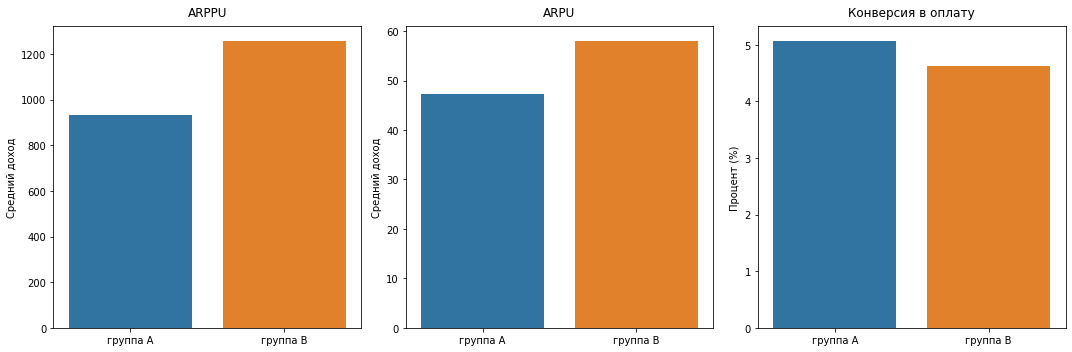

In [51]:
def plot_metrics(metrics, palette="pastel"):

     # Преобразуем входные данные в DataFrame
    df_metrics = pd.DataFrame(metrics).T
    
    #общий заголовок
    plt.suptitle('Сравнение ключевых метрик по группам', fontsize=14, y=1.05)
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette(palette, n_colors=len(df_metrics.columns))
    
    #ARPPU
    plt.subplot(1, 3, 1)
    ax1 = sns.barplot(x=df_metrics.columns, y=df_metrics.loc['ARPPU'])
    plt.title('ARPPU', fontsize=12, pad=10)
    plt.ylabel('Средний доход', fontsize=10)
    

    #ARPU
    plt.subplot(1, 3, 2)
    ax2 = sns.barplot(x=df_metrics.columns, y=df_metrics.loc['ARPU'])
    plt.title('ARPU', fontsize=12, pad=10)
    plt.ylabel('Средний доход', fontsize=10)
    
    # Конверсия в оплату
    plt.subplot(1, 3, 3)
    ax3 = sns.barplot(x=df_metrics.columns, y=df_metrics.loc['Конверсия в оплату'])
    plt.title('Конверсия в оплату', fontsize=12, pad=10)
    plt.ylabel('Процент (%)', fontsize=10)
    
  

    plt.tight_layout()
    plt.show()
    
plot_metrics(metrics)